# Tweet-Clustering: FastText Embeddings

In [1]:
import numpy as np
import pandas as pd
import imp
import lexrank
from matplotlib import pyplot as plt
from data_providers import DummyDataProvider, CachedSmallDataProvider
from clustering import DummyClustering, KMeansClustering, KMeansClusteringNew
from preprocessors import DummyPreprocessor, Cleaner
from vectorizers import DummyVectorizer, FastTextMeanVectorizer, FastTextTfIdfMeanVectorizer, TfIdfVectorizer, ElmoVectorizer, FastTextMeanVectorizerVocabDic
from sentiment import VaderSentimentAnalyser
from labeler import LexRankSummarizer
import utils
import random

In [2]:
dataProvider1 = CachedSmallDataProvider("iphone")
tweets1 = dataProvider1.load_data()
print("number ", len(tweets1))
tweets1[:10]

number  7190


['Create awesome custom faces for your #AppleWatch. Download AWC Faces #iphone #app https://t.co/ctiK1X9Kda',
 "iPhone App 'Timetable of Life':know the time given to you https://t.co/qUNNYiu5Rl #diary #health #horoscope #crossroads #calendar #iPhone #App",
 'New iphone 11 in stock now! Get them while they’re still cheap!! Shoot us a dm! #cheap #iPhone #electronics',
 'The way I see it is, if Apple refuses to unlock an iPhone in a terror investigation, then they are supporting terrorism.  Those buying their products are supporting terrorism. #iphone #Apple #DOJ',
 "The \u2066@FBI\u2069 has the tools it needs to break into the #iPhone, and shouldn't ask for #backdoors https://t.co/FQ3oV2SGfm",
 "#Apple Launches 'Shot on #iPhone' Night Mode #PhotoContest (And Winners Will Get Paid) --&gt; https://t.co/VPOIdpRcYY via @petapixel #photography #cinematographer #video https://t.co/Tu4K6dP9ju",
 'My #iPhone audio was fucked up.   I could hear people but people could not hear me (for an entire m

In [3]:
# 1. DATA
dataProvider2 = CachedSmallDataProvider("alexa")
tweets2 = dataProvider2.load_data()
print("number ", len(tweets2))
tweets2[:1]

number  5469


['He’s so #beautiful love him! 🌸📚💕 #ariemanuel #mymollydoll #blog Thanks for following everyone! We are currently 8.3k share a following with @sassique where I’m a member and Ranked 37,818 in the #US on #Alexa // #blogger #blog #website @WMEBooks #thoughts 📖 https://t.co/m2RitarZYP']

In [4]:
# DATA
dataProvider3 = CachedSmallDataProvider("brexit")
tweets3 = dataProvider3.load_data()
print("number ", len(tweets3))
tweets3[:1]

number  71827


["Hey @tracey_crouch @TomTugendhat  Is this one of those #Brexit divedends for Kent we've been hearing so much about? https://t.co/hT85eKXHZz"]

In [5]:
# DATA
dataProvider4 = CachedSmallDataProvider("baseball")
tweets4 = dataProvider4.load_data()
print("number ", len(tweets4))
tweets4[:1]

number  3739


['Hey @MLB how about some justice for @PeteRose_14 he did nothing compared to the @astros #baseball']

In [6]:
# DATA
dataProvider5 = CachedSmallDataProvider("iran")
tweets5 = dataProvider5.load_data()
print("number ", len(tweets5))
tweets5[:1]

number  35167


['Can the #US bomb #Iran? Defense chief #Esper says no, then changes mind  https://t.co/avZn4sg8tt https://t.co/zLvik6fv87']

In [7]:
# DATA
dataProvider6 = CachedSmallDataProvider("trump")
tweets6 = dataProvider6.load_data()
print("number ", len(tweets6))
tweets6[:1]
# Result 22 clusters (sa) - highly polarized

number  34991


['@Farcethemusic And I say... 🎶 “let’s Build A Wall around the White House &amp; then let’s lock him up”https://t.co/UAYJTZQCff #CountryMusic #Country #Nashville #POTUS #Trump #BananaRepublic #2020Election #AbuseOfPower #Americana #25thAmendmentNow #AltFolk #NewMusicAlert #NewMusic #Ukrainegate']

In [8]:
#merge tweets
tweets = tweets1

#random.shuffle(tweets)

In [9]:
# needs reduction
tweets = tweets[:1000]

In [10]:
cleaner = Cleaner()
# does various clean up-jobs
vocabDicFreq, vocabDic,clean_tweets = cleaner.clean_tweets(tweets, 2 )

In [11]:
# corpus information before threshold removal
# Corpus Information cleaned tweets
sortedDicFreq = {k: v for k, v in sorted(vocabDicFreq.items(), key=lambda item: item[1], reverse=True)}
listeWords = list(sortedDicFreq.keys())
listeValues = list(sortedDicFreq.values())
for element in listeWords[:10]:
    print(element, " : ", sortedDicFreq[element])
pd.Series(listeValues).describe().T

iphone  :  1192
  :  1131
apple  :  432
android  :  144
new  :  115
ios  :  110
ipad  :  105
phone  :  91
samsung  :  86
tech  :  80


count    1172.000000
mean       10.361775
std        50.514016
min         3.000000
25%         3.000000
50%         4.000000
75%         8.000000
max      1192.000000
dtype: float64

In [12]:
# test cleaning and vocab
print(clean_tweets[:1])

['create awesome faces applewatch download faces iphone app']


# TF_IDF CLUSTERING ON FULL TWEET

In [13]:
vectorizer = FastTextMeanVectorizerVocabDic()

In [14]:
# preVectorize - TD IDF IS NOT USED
preVectorizer = TfIdfVectorizer()
docSparse = preVectorizer.vectorize(vocabDic, clean_tweets)
# test tfidf vectors
print("Sparse Vectors shape")
print("laenge pro vector = vocabSize ", len(docSparse[0]))
print("anzahl der dokumente ", len(docSparse))
#print(docSparseTfIdf[0])
#print(vocabDic)
# better


Sparse Vectors shape
laenge pro vector = vocabSize  1172
anzahl der dokumente  1000


In [15]:
# vectorize - much faster laufzeit for clustering
vecs = vectorizer.vectorize(docSparse,vocabDic)
print ("word2vec vectors shape")
print(vecs.shape)
print()

word2vec vectors shape
(1000, 300)



# Find optimal number for k-means with three coefficients +1 optimal
1. silhouette_score - 
a: The mean distance between a sample and all other points in the same class.
b: The mean distance between a sample and all other points in the next nearest cluster.
formula: s = (b-a) / max (a,b)
Problem: prone to 1 point clusters....

2. calinski_harabasz_score - verteilung der cluster und innere Dichte - looks at ALL
Ratio of between cluster dispersion mean and the within cluster dispersion -> higher better 

3. davies_bouldin_score: looks only at nearest cluster
The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Formula: Rij = (si + sj)  / dij with_ s(imiliarity) within cluster, ie. average distance of points to centroid, and d(istance) between cluster-centroids. -> DB = 1/k Sum max Rij (with i != j)


In [16]:
# setting for kmeans clustering n-cluster min and max
min = 2
max = 66

In [17]:
# 2.A. Determina optimal number of cluster - other method - with hashtags - only 2/3s due to duplicates can be checked
# DIFFERENT SETTINGS FOR optimal number of clusters i.e. init="k-means++", max_iter etc. pp.
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
clusterer = KMeansClusteringNew()
SA = {}
CH = {}
DB = {}
for index in range(min, max):
    cluster_labels = clusterer.cluster(vecs, index)
    SA[index] = silhouette_score(vecs, cluster_labels)
    CH[index] = calinski_harabasz_score(vecs, cluster_labels)
    DB[index] = davies_bouldin_score(vecs, cluster_labels)

# find minimum and Maximum
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=True)}
bestSAIndex = next(iter(sortedSA))
print(" SA best ", bestSAIndex, " : ", SA[bestSAIndex] )
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=False)}
worstSAIndex = next(iter(sortedSA))
print(" SA worst ", worstSAIndex, " : ", SA[worstSAIndex] )
#print("SA", pd.Series(list(SA.values())).describe().T)
# ++++++++++++++++++++++++++++++++++++++
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=True)}
bestCHIndex = next(iter(sortedCH))
print(" CH best ", bestCHIndex, " : ", CH[bestCHIndex] )
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=False)}
worstCHIndex = next(iter(sortedCH))
print(" CH worst ", worstCHIndex, " : ", CH[worstCHIndex] )
#print("CH", pd.Series(list(CH.values())).describe().T)
# +++++++++++++++++++++++++++++++++++++++++
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=False)}
bestDBIndex = next(iter(sortedDB))
print(" DB best ", bestDBIndex, " : ", DB[bestDBIndex] )
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=True)}
worstDBIndex = next(iter(sortedDB))
print(" DB worst ", worstDBIndex, " : ", DB[worstDBIndex] )
#print("DB", pd.Series(list(DB.values())).describe().T)

# ++++++++++++++ create mixed ranking
Ranking = {}
for index in range(min, max):
    Ranking[index] = SA[index]/SA[bestSAIndex] + CH[index]/CH[bestCHIndex] - DB[index]/DB[worstDBIndex]
    #print(Ranking[index])
sortedRanking = {k: v for k, v in sorted(Ranking.items(), key=lambda item: item[1], reverse=True)}
count = 10
for key, value in sortedRanking.items():
    count -=1
    print(key, " ", value, " Silhouette ", SA[key])
    if count == 0:
        break

 SA best  44  :  0.11010201254230478
 SA worst  11  :  -0.014748700551768064
 CH best  4  :  55.250385899578944
 CH worst  64  :  16.951149226190655
 DB best  65  :  1.7740207017694825
 DB worst  3  :  3.4270839829065207
44   0.7815158975532505  Silhouette  0.11010201254230478
38   0.7763682638303722  Silhouette  0.10839736667630417
65   0.7637076422289583  Silhouette  0.10589410826406467
56   0.7440973639503642  Silhouette  0.10829627200397322
64   0.7434291728217064  Silhouette  0.10736069748715654
37   0.7411385873935001  Silhouette  0.10521650181646935
47   0.7395340059073972  Silhouette  0.10604003743140221
27   0.7366143498244195  Silhouette  0.09777902724567258
48   0.7364252591531352  Silhouette  0.1069985583317611
43   0.7303519311215372  Silhouette  0.104739407143767


In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
bandwidth = estimate_bandwidth(vecs, quantile=0.2, n_samples=1000)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(vecs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

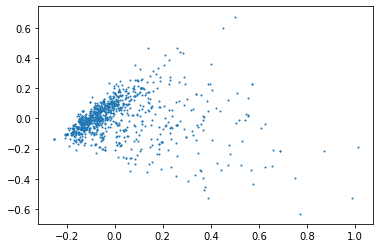

In [18]:
# graph
print()
utils.scatter2d(vecs)


# distribution of clusters

In [19]:
cluster_optimal_number = 60

In [20]:
# cluster assignement numbers
cluster_assignments = clusterer.cluster(vecs, cluster_optimal_number)
print( "cluster assignments: ")
clusterCount = pd.Series(cluster_assignments).value_counts()
print(clusterCount.describe().T)
print(clusterCount)



cluster assignments: 
count    60.000000
mean     16.666667
std      17.077755
min       1.000000
25%       4.000000
50%      10.500000
75%      20.000000
max      68.000000
dtype: float64
19    68
2     59
11    56
5     55
21    53
40    48
39    47
6     42
47    42
37    37
1     26
55    26
38    22
7     21
13    20
23    20
8     19
27    18
14    18
44    17
12    17
0     17
42    16
51    16
20    15
33    13
29    13
4     12
9     11
43    11
32    10
25    10
3     10
15    10
16    10
41     8
24     7
56     7
54     7
50     7
31     5
35     5
59     5
17     5
10     4
36     4
52     4
22     3
53     3
26     3
18     3
46     3
45     3
49     2
48     2
28     1
34     1
58     1
30     1
57     1
dtype: int64


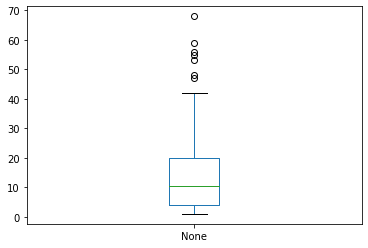

In [21]:
clusterCount.plot.box()

For n_clusters = 60 The average silhouette_score is : 0.15192321269485887


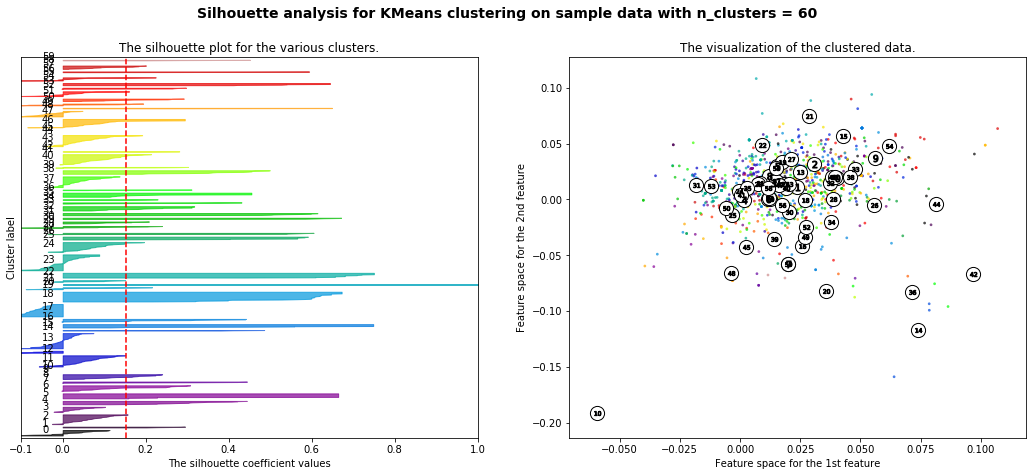

In [22]:
# analyser TFIDF
min = cluster_optimal_number
max = cluster_optimal_number + 1
clusterer.silhouette_analyser(vecs, min, max)




In [23]:
def sentiment(df):
    sentiment_analyser = VaderSentimentAnalyser()
    sentiments = sentiment_analyser.get_sentiment(clean_tweets)
    df['sentiment'] = sentiments
    df.sort_values(by=['cluster'], inplace=True, ascending=True)
    print(df.groupby(['cluster'])['sentiment'].mean())
    # give min, max and mean "tweets"
    print(df.nsmallest(20, 'sentiment'))
    print(df.nlargest(20, 'sentiment'))
    
    #sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=False)}


In [24]:
def topWords(df, clusterNum):
#find 10 most frequent words for each cluster
# vars
    clusterNumber = clusterNum
    clusterStr = ["" for i in range(clusterNumber)]
    topTex = [[] for i in range(clusterNumber)]
    clusterSent =[0 for i in range(clusterNumber)]
    for index in range(len(clean_tweets)):
        cluster = df.at[index, 'cluster']
        string = clusterStr[cluster]
        string += str(df.at[index, 'tweets'])
        string += " "
        clusterStr[cluster] = string
    # sort 
    # clean and count words in 
    for index in range(clusterNumber):
        liste1 = ["", clusterStr[index]]
        vocabDicFreq2, vocabDic2, clean_tweets2 = cleaner.clean_tweets(liste1, 0)
        sortedDicFreq = {k: v for k, v in sorted(vocabDicFreq2.items(), key=lambda item: item[1], reverse=True)}
        liste = list(sortedDicFreq.keys())
        topTex[index] = liste[:10]
    for index in range(clusterNumber):
        print("Cluster ", index, " top 10: ", topTex[index])
        


In [25]:
dictClusterTweets = {'cluster':cluster_assignments, 'tweets':clean_tweets}
df = pd.DataFrame(dictClusterTweets)
df['Counts'] = df.groupby(['cluster']).transform('count')
pd.options.display.max_colwidth = 4000
pd.set_option('display.max_rows', df.shape[0]+1)

topWords(df, cluster_optimal_number)

Cluster  0  top 10:  ['iphone', '', 'apple', 'samsung', 'case', 'plus', 'twitter', 'enjoy', '11pro', '64gb']
Cluster  1  top 10:  ['iphone', 'art', 'photo', 'cases', 'shop', 'photography', 'case', 'fractal', 'pattern', 'redbubble']
Cluster  2  top 10:  ['iphone', 'ios', 'apple', 'ipad', 'android', 'game', 'free', 'mobile', 'app', 'facebook']
Cluster  3  top 10:  ['iphone', 'new', 'one', 'year', 'old', 'years', 'samsung', '', 'time', 'issue']
Cluster  4  top 10:  ['iphone', 'us', 'dm', 'iphones', '8plus', 'jaiiryda', 'inquiries', 'check', 'web', 'free']
Cluster  5  top 10:  ['iphone', 'user', 'dynamic', 'portrait', 'digitalart', 'cyberart', 'new', 'art', 'liquidart', 'ridiculous']
Cluster  6  top 10:  ['iphone', 'apple', 'phone', 'new', 'time', 'one', 'years', 'day', '2020', 'better']
Cluster  7  top 10:  ['found', 'roboticode', 'android', 'iphone', 'kindle', 'dailyinspiration', 'bible', 'verse', 'daily', 'prayers']
Cluster  8  top 10:  ['radio', 'power', 'blast', 'play', 'iphone', 'web

In [26]:
sentiment(df)

cluster
0     0.569035
1     0.601917
2     0.618346
3     0.545880
4     0.719858
5     0.678851
6     0.713404
7     0.603295
8     0.670000
9     0.876914
10    0.557350
11    0.646154
12    0.608403
13    0.567682
14    0.599214
15    0.563690
16    0.402800
17    0.850180
18    0.835567
19    0.562345
20    0.505160
21    0.517615
22    0.340900
23    0.538490
24    0.635357
25    0.522020
26    0.899667
27    0.656417
28    0.500000
29    0.553188
30    0.690900
31    0.560370
32    0.625000
33    0.521319
34    0.576550
35    0.709320
36    0.682613
37    0.725851
38    0.590673
39    0.560496
40    0.523981
41    0.665538
42    0.547994
43    0.472832
44    0.643326
45    0.613467
46    0.799700
47    0.622088
48    0.500000
49    0.500000
50    0.889150
51    0.684203
52    0.500000
53    0.309100
54    0.522729
55    0.620254
56    0.549729
57    0.500000
58    0.500000
59    0.601870
Name: sentiment, dtype: float64
     cluster  \
400       44   
237       19   
952       21

In [ ]:
df["sentiment"].describe().T